In [1]:
import opensimplex
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
from typing import Optional
from scipy import interpolate
import sympy
from bisplev.supports_sympy import fpbisp

%matplotlib inline

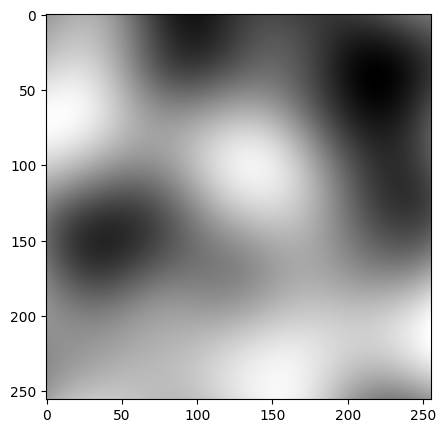

In [2]:
def create_discrete_field(
  octaves: int,
  persistence: float,
  lacunarity: float,
  scale: float,
  resolution: int,
  verbose: bool = False,
  seed: Optional[int] = None,
  delta_z: float = 100
) -> np.ndarray:

  if seed is not None:
    opensimplex.seed(seed)

  field = np.zeros((resolution, resolution))

  strength = 1
  frequency = scale
  z = 0
  with tqdm(total=resolution*resolution*octaves, leave=False, disable=not verbose) as pbar:
    for _ in range(octaves):

      for y in range(resolution):
        for x in range(resolution):
          v = y/(resolution-1) * frequency
          u = x/(resolution-1) * frequency

          noise = strength * opensimplex.noise3(u, v, z)
          field[y][x] += noise

          pbar.update()

      z += delta_z
      strength *= persistence
      frequency *= lacunarity
  
  amplitude = 0.864366 * (1.-persistence**octaves) / (1.-persistence)
  assert np.all((field < amplitude) & (field >= -amplitude)), (np.min(field), np.max(field))

  return (field / amplitude + 1.)/2.


if __name__ == "__main__":
  field = create_discrete_field(
    octaves=1,
    persistence=0.9,
    lacunarity=2,
    scale=3,
    resolution=256,
    verbose=True,
    seed=1
  )

  fig, ax = plt.subplots(figsize=(5, 5))

  ax.imshow(field, cmap="gray")

Calculating wx...


Calculating wy...


Calculating c...


Calculating z...


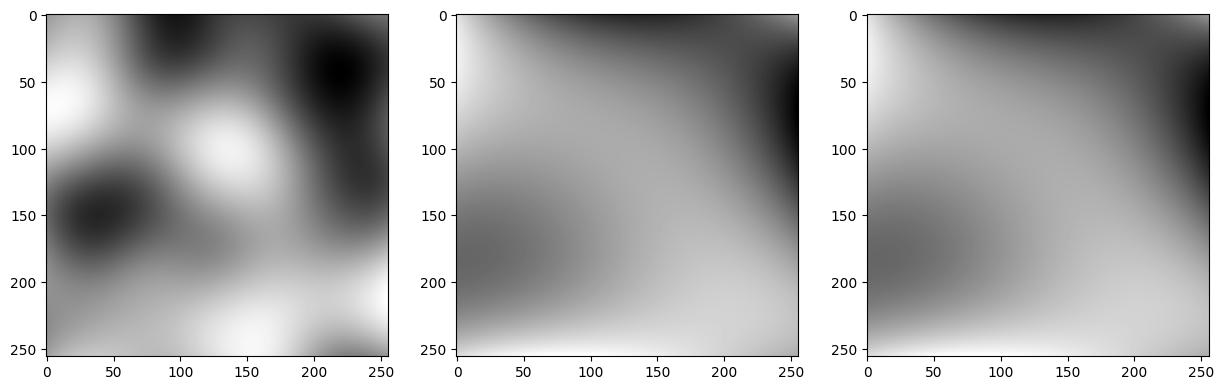

In [6]:
def fit_spline_surface(
  field: np.ndarray
):
  y, x = field.shape
  vs = np.linspace(0, 1, y)
  us = np.linspace(0, 1, x)

  zs = field.reshape((-1,))

  tck, fp, ier, msg = interpolate.bisplrep(np.tile(us, y), np.repeat(vs, x), zs, full_output=1, s=1024)
  
  xs = np.linspace(0, 1, 256)
  ys = np.linspace(0, 1, 256)

  # tx, ty, c, kx, ky = tck
  # print(f"tx=np.array({tx.tolist()})")
  # print(f"ty=np.array({ty.tolist()})")
  # print(f"c=np.array({c.tolist()})")
  # print(f"kx={kx}")
  # print(f"ky={kx}")

  assert ier <= 0
  
  v = interpolate.bisplev(xs, ys, tck).T
  return v, fpbisp(*tck, *sympy.symbols("x y"), verbose=True)


if __name__ == "__main__":
  scipy_constructed, formula = fit_spline_surface(field)
  # f = sympy.lambdify(("x", "y"), formula)

  res = 256
  reconstructed_field = np.empty((res, res))
  with tqdm(total=res*res, leave=False) as pbar:
    for y in range(res):
      for x in range(res):
        v = y/(res-1)
        u = x/(res-1)

        f_ = float(formula.subs("x", u).subs("y", v))
        reconstructed_field[y][x] = f_
        pbar.update()

  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  axs[0].imshow(field, cmap="gray")
  axs[1].imshow(reconstructed_field, cmap="gray")
  axs[2].imshow(scipy_constructed, cmap="gray")